In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/s_csmscox/jupyterSave/dvc/train'
validation_dir = 'C:/Users/s_csmscox/jupyterSave/dvc/valid'

# ImageDataGenerator를 생성
# train data를 생성해주는 ImageDataGenerator, validation data를 생성해주는 ImageDataGenerator를 각각 만들어야 해요!
# 미리 데이터를 불러오는게 아니라 학습할 때마다 배치 사이즈 만큼 불러와 메모리 아낌
# 하지만 느림

batch_size = 20

train_datagen = ImageDataGenerator(rotation_range=20,  # 지정된 각도 범위내에서 임의로 원본 이미지를 회전
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,    #  1-수치 혹은 1+수치만큼 확대 및 축소
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,     # target directory
    classes=['0', '1'],   # cats, dogs 순서로 label 0, 1로 설정
                                # 만약 classes 속성을 생략하면 폴더 순서로 label이 결정 
    target_size=(224,224),      # 일반적으로 정사각형 행태로 resize (resize 크기는 CNN의 구조에 따라서 달라져요!)                         
    batch_size=batch_size,              # 한번에 32개의 image 파일을 가져와서 pixel데이터로 변환
                                # label에 상관없이 가져와요!      
    class_mode='categorical'         # 고양이와 멍멍이 2개의 label만 존재하기 때문에 2진분류이고 binary classification
                                # 다중분류인 경우 'categorical'을 이용해요(default 값) - (one-hot encoding)
                                # 'sparse'도 이용가능해요                    
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,             # target directory
    classes=['0', '1'],   # cats, dogs 순서로 label 0, 1로 설정
                                # 만약 classes 속성을 생략하면 폴더 순서로 label이 결정 
    target_size=(224,224),      # 일반적으로 정사각형 행태로 resize (resize 크기는 CNN의 구조에 따라서 달라져요!)                         
    batch_size=batch_size,              # 한번에 20개의 image 파일을 가져와서 pixel데이터로 변환
                                # label에 상관없이 가져와요!      
    class_mode='categorical'         # 고양이와 멍멍이 2개의 label만 존재하기 때문에 2진분류이고 binary classification
                                # 다중분류인 경우 'categorical'을 이용해요(default 값) - (one-hot encoding)
                                # 'sparse'도 이용가능해요                    
)


Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

np.random.seed(42)

# 모델 구축

# vgg16 모델 불러오기
pre_trained_model = EfficientNetB0(include_top=False, weights='imagenet',
                                  input_shape=(224, 224, 3))
pre_trained_model.trainable = False
pre_trained_model.summary()

# vgg16 모델에 덧붙이기
model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              256905216 
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 271,445,669
Trainable params: 267,396,098
Non-trainable params: 4,049,571
________________________________

In [4]:
#모델 학습
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 15000 / batch_size
val_steps = 5000 / batch_size

histroy = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/30
750/750 [==============================] - 145s 194ms/step - loss: 0.5079 - accuracy: 0.7509 - val_loss: 0.2067 - val_accuracy: 0.9424
Epoch 2/30
750/750 [==============================] - 147s 196ms/step - loss: 0.2679 - accuracy: 0.8948 - val_loss: 0.1198 - val_accuracy: 0.9670
Epoch 3/30
750/750 [==============================] - 146s 194ms/step - loss: 0.2063 - accuracy: 0.9195 - val_loss: 0.0902 - val_accuracy: 0.9738
Epoch 4/30
750/750 [==============================] - 144s 193ms/step - loss: 0.1747 - accuracy: 0.9310 - val_loss: 0.0758 - val_accuracy: 0.9770
Epoch 5/30
750/750 [==============================] - 146s 194ms/step - loss: 0.1522 - accuracy: 0.9380 - val_loss: 0.0676 - val_accuracy: 0.9784
Epoch 6/30
750/750 [==============================] - 145s 193ms/step - loss: 0.1421 - accuracy: 0.9451 - val_loss: 0.0617 - val_accuracy: 0.9802
Epoch 7/30
750/750 [==============================] - 147s 197ms/step - loss: 0.1319 - accuracy: 0.9486 - val_loss: 0.0577 -

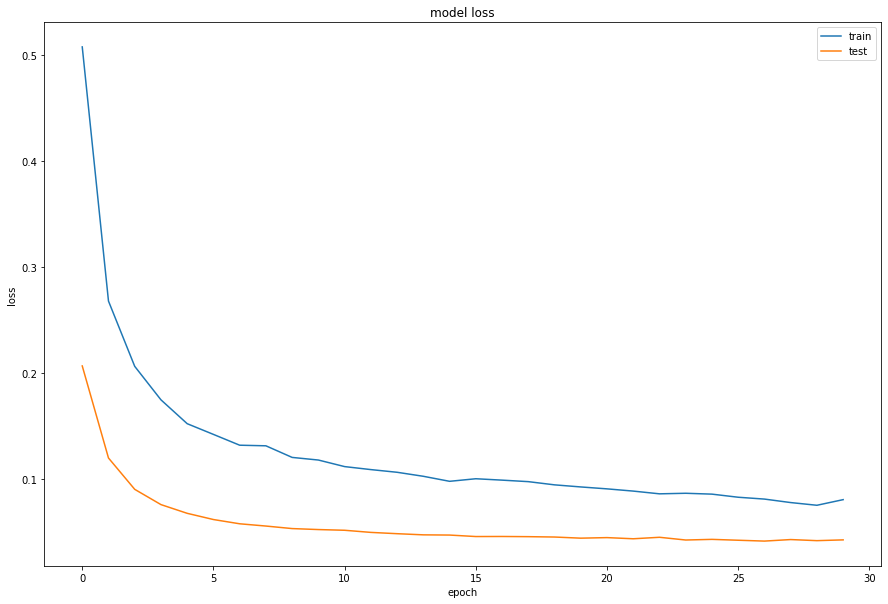

train loss= 0.08047676831483841
validation loss= 0.04249286279082298


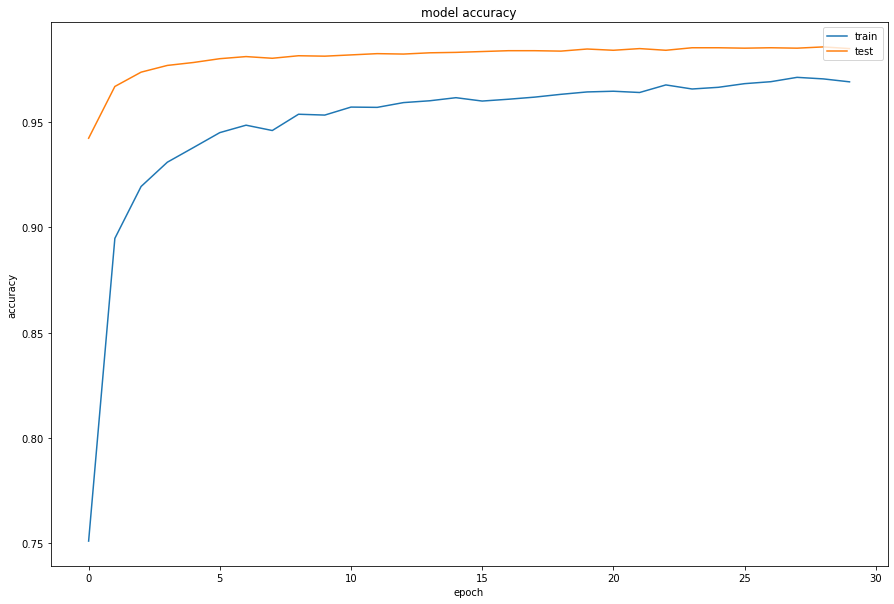

train accuracy= 0.9692000150680542
validation accuracy= 0.9850000143051147


In [5]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(histroy)
plot_acc_curve(histroy)

In [6]:
model.save('C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_224')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_224\assets


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('C:/Users/s_csmscox/jupyterSave/dvc/dvc_EfficientNetB0_224')

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20

test_dir = 'C:/Users/s_csmscox/jupyterSave/dvc/test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    classes=['0', '1'], 
    target_size=(224,224),                       
    batch_size=batch_size,    
    class_mode='categorical'
)


In [ ]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report

#y_pred와 y_test를 일차원 배열로 만드는 함수
def y_to_list(y_pred, y_test):
    yp = []
    yt = []
    for i in y_pred:
        idx = 0
        m = 0
        for j in range(0,2):
            if(i[j]>m):
                m = i[j]
                idx = j
        yp.append(idx)
    
    for i in y_test:
        idx = 0
        for j in range(0,2):
            if(i[j]==1):
                idx = j
                break
        yt.append(idx)
    
    return yp, yt

#모델 예측 및 classification_report를 통한 평가
y_pred = model.predict(test_generator)

yp, yt = y_to_list(y_pred, y_test)

target_names = ['cat', 'dog']
print(classification_report(yt, yp, target_names=target_names))

In [ ]:
img = Image.open('C:/Users/s_csmscox/jupyterSave/cat.jpg')

img = img.resize((224,224))
        
img = np.asarray(img)
img = img.reshape(224,224,3)

plt.imshow(img)
plt.show()

img = img/255

img = img.reshape(1,224,224,3)
pred = model.predict(img)

for i in pred:
    m = i.max()
    for j in range(2):
        if i[j] == m:
            if j == 0:
                print("예측 : 고양이")
            else:
                print("예측 : 강아지")
